In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORT LIBRARY

In [2]:
!pip install scikeras

  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.1
    Uninstalling scikit-learn-1.3.1:
      Successfully uninstalled scikit-learn-1.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop



In [4]:
!pip install -q -U keras-tuner

# DATA UNDERSTANDING

In [5]:
true_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLT submission 1/fake and real news dataset/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLT submission 1/fake and real news dataset/Fake.csv')

In [6]:
true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df], axis=0).sample(frac=1).reset_index(drop=True)
df.head(10)

,title,text,subject,date,label
0,Story Withdrawn: Wealthy win in U.S. House tax...,WASHINGTON (Reuters) - Please note that the st...,politicsNews,"November 6, 2017",1
1,U.S. judge blocks Trump order to restrict fund...,SAN FRANCISCO (Reuters) - A U.S. judge on Tues...,politicsNews,"April 25, 2017",1
2,China jails 44 Taiwanese for fraud in case den...,BEIJING/TAIPEI (Reuters) - A Beijing court on ...,worldnews,"December 21, 2017",1
3,China top graft buster says corruption fight '...,BEIJING (Reuters) - Fixing the corruption prob...,worldnews,"September 21, 2017",1
4,OBAMA AND UNION LEADERS SELL OUT AMERICAN WORK...,This story just proves what we ve been saying ...,left-news,"Apr 8, 2015",0
5,WATCH HILLARY CLINTON BARK Like A Dog During S...,Democrat presidential candidate Hillary Clinto...,politics,"Feb 16, 2016",0
6,"On bike, horse and foot, police keep order out...",CLEVELAND (Reuters) - City police on bicycles ...,politicsNews,"July 20, 2016",1
7,White House says Iran's progress on nuclear de...,WASHINGTON (Reuters) - Iran has made important...,politicsNews,"January 15, 2016",1
8,‘Good Guy With A Gun’ Accidentally Shoots Wom...,You know how the NRA constantly tells us that ...,News,"November 18, 2016",0
9,Trump FBI nominee's corporate legal work could...,NEW YORK (Reuters) - President Donald Trump’s ...,politicsNews,"June 7, 2017",1


<ipython-input-7-2715736294>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


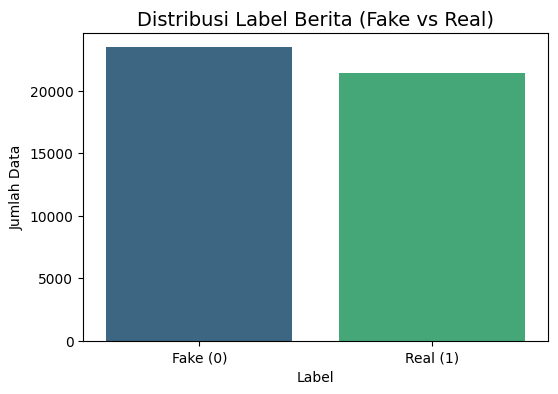

label
0    23481
1    21417
Name: count, dtype: int64


In [7]:
# Visualisasi distribusi label
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Label Berita (Fake vs Real)', fontsize=14)
plt.xticks([0, 1], ['Fake (0)', 'Real (1)'])
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

print(df['label'].value_counts())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [9]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [10]:
df['text'].duplicated().sum()

6252

In [11]:
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Insight:**


*   Dataset terdiri dari 2 file yang berbeda yaitu True.csv dan Fake.csv yang nama masing masing file sesuai dengan kelas aktualnya
*   Jumlah dataset awal adalah 44898 data
*   Dataset memiliki 4 kolom bawaan, yaitu title, text, subject dan date. seluruh kolom bertipe data String
*   Dataset digabungkan menjadi satu dataframe dengan tambahan kolom label dengan tipe data integer yaitu 0 untuk fake dan 1 untuk true
*   Distribusi label terdiri dari 23481 label fake dan 21417 label true
*   Dataset memiliki 6252 data duplikat

# DATA PREPARATION

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    return text

df['text'] = df['text'].apply(clean_text)

In [13]:
df = df.drop_duplicates(subset='text', keep='first')
df['text'].duplicated().sum()

0

In [14]:
max_words = 5000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ukuran total data
print("Total data:", len(X))

# Ukuran test
print("Test data:", len(X_test))

# Ukuran train sebelum di-split validation
print("Train total (before validation split):", len(X_train))

# Ukuran validation (20% dari train)
val_size = int(0.2 * len(X_train))
print("Validation data (from train):", val_size)

# Ukuran train sesungguhnya (80% dari train)
print("Final training data:", len(X_train) - val_size)


Total data: 38594
Test data: 7719
Train total (before validation split): 30875
Validation data (from train): 6175
Final training data: 24700


**Insight:**


*   Dilakukan cleansing data untuk kolom text menggunakan lowering case, menghapus teks didalam tanda kurung siku, menghapus URL, menghapus tag HTML, menghapus tanda baca, dan membuat teks menjadi satu baris
*   dilakukan penghapusan data yang duplikat karena sebelumnya terdeteksi adanya data yang duplikat
*   dilakukan tokenisasi terhadap data teks
*   dilakukan split dataset dengan data training 80%, validation 10% dan test 10%



# MODELING

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',     # Pantau loss validasi
    patience=3,             # Stop jika tidak membaik selama 3 epoch
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Turunkan LR jika val_loss stagnan
    factor=0.5,             # Turunkan LR sebesar 50%
    patience=2,             # Setelah 2 epoch tanpa perbaikan
    min_lr=1e-6             # Minimal LR
)

In [17]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop, reduce_lr])

Epoch 1/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 175s 448ms/step - accuracy: 0.8738 - loss: 0.3273 - val_accuracy: 0.9731 - val_loss: 0.0957 - learning_rate: 0.0010
Epoch 2/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 190s 418ms/step - accuracy: 0.9536 - loss: 0.1336 - val_accuracy: 0.9781 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 211s 443ms/step - accuracy: 0.9783 - loss: 0.0698 - val_accuracy: 0.9845 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 4/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 172s 446ms/step - accuracy: 0.9857 - loss: 0.0475 - val_accuracy: 0.9783 - val_loss: 0.0764 - learning_rate: 0.0010
Epoch 5/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 205s 452ms/step - accuracy: 0.9744 - loss: 0.0788 - val_accuracy: 0.9765 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 6/100
386/386 ━━━━━━━━━━━━━━━━━━━━ 202s 452ms/step - accuracy: 0.9881 - loss: 0.0406 - val_accuracy: 0.9828 - val_loss: 0.0617 - learning_rate: 5.0000e-04


**Insight:**


*   Menggunakan Early Stopping dalam proses pemodelan untuk menghindari overfitting dan menghemat waktu pelatihan
*   Menggunakan Reduce Learning Rate untuk mengadaptasi learning rate saat model stagnan untuk hasil yang lebih optimal
*   Arsitektur model yang digunakan terdiri dari empat lapisan utama yang dirancang untuk mendeteksi berita palsu berbasis teks. Model dimulai dengan lapisan Embedding yang mengubah setiap kata menjadi vektor berdimensi 128 untuk merepresentasikan makna kata dalam bentuk numerik, dengan panjang input sesuai jumlah token maksimum (max_len). Selanjutnya, vektor tersebut diproses oleh LSTM (Long Short-Term Memory) dengan 64 unit yang mampu menangkap hubungan kontekstual antar kata dalam urutan teks. Setelah itu, diterapkan Dropout sebesar 0.5 untuk mencegah overfitting dengan menonaktifkan sebagian neuron secara acak selama pelatihan. Terakhir, output diarahkan ke Dense layer dengan 1 neuron dan fungsi aktivasi sigmoid untuk menghasilkan probabilitas klasifikasi biner, yaitu apakah suatu berita tergolong palsu atau nyata.
*    Model dilatih menggunakan fungsi loss binary crossentropy dan optimizer Adam selama maksimal 100 epoch dengan batch size 64. Untuk mencegah overfitting dan mempercepat pelatihan, digunakan EarlyStopping yang menghentikan training jika val_loss tidak membaik selama 3 epoch. Selain itu, ReduceLROnPlateau menurunkan learning rate sebesar 50% jika val_loss stagnan selama 2 epoch. Sebanyak 20% data training digunakan sebagai validasi, sehingga kinerja model dapat dipantau dan disesuaikan secara dinamis selama proses pelatihan.

# EVALUATION

In [23]:
# Prediksi hasil (nilai probabilitas sigmoid)
y_pred_prob = model.predict(X_test)

# Konversi ke 0 dan 1
y_pred = (y_pred_prob > 0.5).astype(int)

242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step


In [24]:
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))

Accuracy: 0.9839
Precision: 0.9792
Recall: 0.9920
F1 Score: 0.9855


In [25]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))



Classification Report:

              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      3458
        Real       0.98      0.99      0.99      4261

    accuracy                           0.98      7719
   macro avg       0.98      0.98      0.98      7719
weighted avg       0.98      0.98      0.98      7719



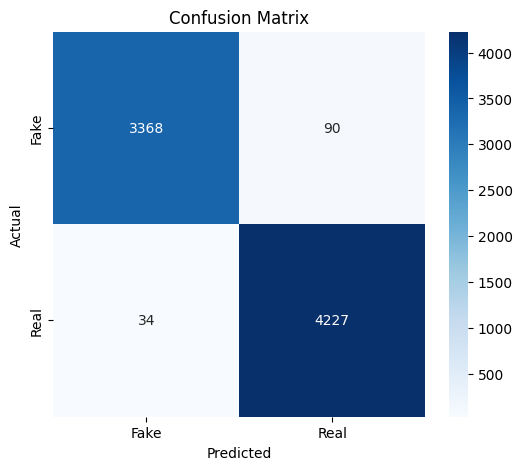

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**insight:**


*   Accuracy 0.9839 = Model secara keseluruhan memprediksi dengan benar sebanyak 98.39%.
*   Precision 0.9729 = Dari seluruh berita yang diprediksi fake, 97.29% benar-benar fake.
*   Recall 0.9920 = Dari seluruh berita yang benar-benar fake, 99.20% berhasil dideteksi model.
*   F1 Score 0.9855 = Rata-rata harmonis antara precision dan recall, menunjukkan keseimbangan performa.
*   Classification report menunjukkan performa model dalam mendeteksi berita palsu dan asli berdasarkan metrik precision, recall, dan F1-score. Untuk kelas "Fake", model mencapai precision sebesar 0.89, artinya 89% dari prediksi berita palsu memang benar palsu, dengan recall sebesar 0.97 yang menunjukkan bahwa 97% dari semua berita palsu berhasil terdeteksi. Sementara untuk kelas "Real", precision dan recall sangat tinggi, masing-masing sebesar 0.98 dan 0.99, menandakan bahwa model sangat akurat dan sensitif dalam mengenali berita asli. Nilai F1-score untuk kedua kelas pun tinggi, yaitu 0.93 untuk Fake dan 0.98 untuk Real, yang mengindikasikan performa model sangat seimbang. Rata-rata makro dan tertimbang dari ketiga metrik tersebut juga sebesar 0.98, menunjukkan bahwa model bekerja sangat baik secara keseluruhan dalam menangani kedua kelas.
*   Confusion matrix menunjukkan bahwa model mampu mengklasifikasikan berita palsu dan asli dengan sangat baik. Dari total data uji, terdapat 3.368 berita palsu yang berhasil diklasifikasikan dengan benar sebagai palsu (true positive), dan hanya 90 berita palsu yang salah dikenali sebagai berita asli (false negative). Sementara itu, sebanyak 4.227 berita asli diklasifikasikan dengan benar (true negative), dan hanya 34 berita asli yang keliru terdeteksi sebagai palsu (false positive). Hasil ini menunjukkan bahwa model memiliki tingkat kesalahan yang sangat rendah dan sangat efektif dalam mengenali kedua kategori berita, dengan kesalahan terbanyak berasal dari berita palsu yang lolos sebagai berita asli.


